In [1]:
import sys
sys.path.append("D:\PythonProject\RebuildProject")
from tensorflow.keras.models import load_model  # For loading a saved model
from matplotlib.ticker import AutoMinorLocator
import mdn  # For Mixture Density Networks
import joblib  # For serialization and deserialization of Python objects
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from sklearn.metrics import r2_score
from Rock.Model.EnsembleMDN import EnsembleMDN
# from tortreinador.utils.plot import calculate_GMM
from tortreinador.utils.View import init_weights
from tortreinador.models.MDN import Mixture, NLLLoss
from tortreinador.utils.metrics import r2_score as r2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import math

In [5]:
df_chunk_0 = pd.read_parquet("D:\\Resource\\rockyExoplanetV3\\data_chunk_0.parquet")
df_chunk_1 = pd.read_parquet("D:\\Resource\\rockyExoplanetV3\\data_chunk_1.parquet")

df_all = pd.concat([df_chunk_0, df_chunk_1])

In [2]:
input_parameters = [
    'Mass',
    'Radius',
    'FeMg',
    'SiMg',
    'Mass_Noise',
    'Radius_Noise',
    'FeMg_Noise',
    'SiMg_Noise'
]

output_parameters = [
    'WRF',
    'MRF',
    'CRF',
    'WMF',
    'CMF',
    'CPS',
    'CTP',
    'k2'
]

In [3]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(scaler_x.fit_transform(df_all[input_parameters[:4]].to_numpy()), scaler_y.fit_transform(df_all[output_parameters].to_numpy()), test_size=0.1, random_state=9887)

In [8]:
_, X_test_pre, _, y_test_pre = train_test_split(X_test, y_test, test_size=0.2, random_state=9887)

In [3]:
OUTPUT_DIMS = len(output_parameters)
N_MIXES = 20

In [9]:
m_2 = keras.models.load_model('D:\\Resource\\MDN\\rockyExoplanetV3\\model.h5', custom_objects={'MDN': mdn.MDN, 'mdn_loss_func': mdn.get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)})

In [17]:
sample_rand_idx = np.random.randint(0, X_test.shape[0], size=20000)

In [18]:
X_test_sampled = X_test[sample_rand_idx]
y_test_sampled = y_test[sample_rand_idx]

In [12]:
mse_function = mdn.get_mixture_mse_accuracy(OUTPUT_DIMS, N_MIXES)
c = mdn.get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)
sample_function = mdn.get_mixture_sampling_fun(OUTPUT_DIMS, N_MIXES)
pred = m_2.predict(X_test_pre)
samples = sample_function(pred)
print("r2 score: {}, MSE: {}, NLLLoss: {}".format(r2_score(y_test_pre, samples),
                                                  np.mean(mse_function(y_test_pre.astype('float32'), pred)),
                                                  np.mean(c(y_test_pre.astype('float32'), pred))))

r2 score: 0.9390722848351685, MSE: 0.0024862459395080805, NLLLoss: -13.057703971862793


In [20]:
mus = np.apply_along_axis((lambda a: a[:N_MIXES * OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES * OUTPUT_DIMS:2 * N_MIXES * OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)
mus = mus.reshape(mus.shape[0], N_MIXES, int(mus.shape[1] / N_MIXES))
sigs = sigs.reshape(sigs.shape[0], N_MIXES, int(sigs.shape[1] / N_MIXES))

In [21]:
tf_GMM = calculate_GMM(pis, mus, sigs)

In [19]:
len(y_test_pre)

70560

In [16]:
tf_test_y_inverse = scaler_y.inverse_transform(y_test_pre)

In [17]:
tf_col_dis = []
for o in range(len(output_parameters)):
    dis = 0
    for i in range(0, tf_GMM.shape[-1], len(output_parameters)):
        test_y_current = tf_test_y_inverse[int(i / len(output_parameters)), o]
        GMM_cal = tf_GMM[:, o + i].reshape(-1, 1)
        offset = np.sqrt((GMM_cal - test_y_current) ** 2)
        dis += np.mean(offset)
    tf_col_dis.append(dis / len(tf_test_y_inverse))

In [18]:
tf_col_dis

[0.12841172626788616,
 0.31344589433927955,
 0.5882560927303219,
 0.12460618537584418,
 0.49255198873747086,
 527.2070480216809,
 3198.7033150023585,
 0.6368219277019227]

In [3]:
t_x = np.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\test_x.npy")
t_y = np.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\test_y.npy")
m_y = joblib.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\MDN_v3_yscaler_20240630.save")

In [49]:
model = EnsembleMDN(int(len(input_parameters) / 2), len(output_parameters), 10, 256, kernel_size=2)
init_weights(model)
model = nn.DataParallel(model)
model.load_state_dict(torch.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\best_model.pth"))

<All keys matched successfully>

In [6]:
rand_idx = torch.randint(0, t_x.shape[0], size=(70560,))
sampled_test_x = t_x[rand_idx]
sampled_test_y = t_y[rand_idx]
t_x_o, t_x_n = np.array_split(sampled_test_x, 2, axis=1)

In [7]:
model.eval()
pred = model(torch.from_numpy(t_x_o), torch.from_numpy(t_x_n))

In [8]:
mix = Mixture()
criterion = NLLLoss()
mse = nn.MSELoss()
sample = mix(pred[0], pred[1], pred[2]).sample()
print("NLLLoss: {}, MSE: {}, R2: {}".format((criterion(pred[0], pred[1], pred[2], torch.from_numpy(sampled_test_y).to('cuda'))),
                                            mse(torch.from_numpy(sampled_test_y).to('cuda'), sample),
                                            r2(sample, torch.from_numpy(sampled_test_y).to('cuda'))))

NLLLoss: -41.0252186617822, MSE: 0.0011328561347307602, R2: 0.9630526833377644


In [9]:
torch_GMM_PDF = calculate_GMM(torch.exp(pred[0]).detach().cpu().numpy(), pred[1].detach().cpu().numpy(), pred[2].detach().cpu().numpy())

In [11]:
torch_test_y_inverse = m_y.inverse_transform(sampled_test_y)

In [12]:
torch_col_dis = []
for o in range(len(output_parameters)):
    dis = 0
    for i in range(0, torch_GMM_PDF.shape[-1], len(output_parameters)):
        test_y_current = torch_test_y_inverse[int(i / len(output_parameters)), o]
        GMM_cal = torch_GMM_PDF[:, o + i].reshape(-1, 1)
        offset = np.sqrt((GMM_cal - test_y_current) ** 2)
        dis += np.mean(offset)
    torch_col_dis.append(dis / len(torch_test_y_inverse))

In [13]:
torch_col_dis

[0.1009618267278057,
 0.3151337696364372,
 0.5907286436619519,
 0.08599745917122328,
 0.4928586250780018,
 527.4741109703947,
 3197.136507810926,
 0.653157348501983]

In [10]:
# Set the random seed for reproducibility
np.random.seed(125)

# Define the function to generate samples and plot histogram
def generate_samples_and_plot(mean, err, title, ax):
    """
    Generates Gaussian distributed samples around a mean with a given error,
    and plots a histogram of the samples.
    
    Parameters:
    - mean: The mean value for the Gaussian distribution.
    - err: The standard deviation (error) for the Gaussian distribution.
    - title: The title of the plot.
    - ax: The matplotlib Axes object on which to plot.
    
    Returns:
    - samples: The generated samples.
    """
    samples = np.random.normal(loc=mean, scale=err, size=1000)
    ax.hist(samples, bins=50, color='steelblue', edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2)  # Mark the mean value
    ax.fill_between([mean-err, mean+err], [0, 0], [100, 100], alpha=0.2, color='green')  # Highlight the error range
    return samples

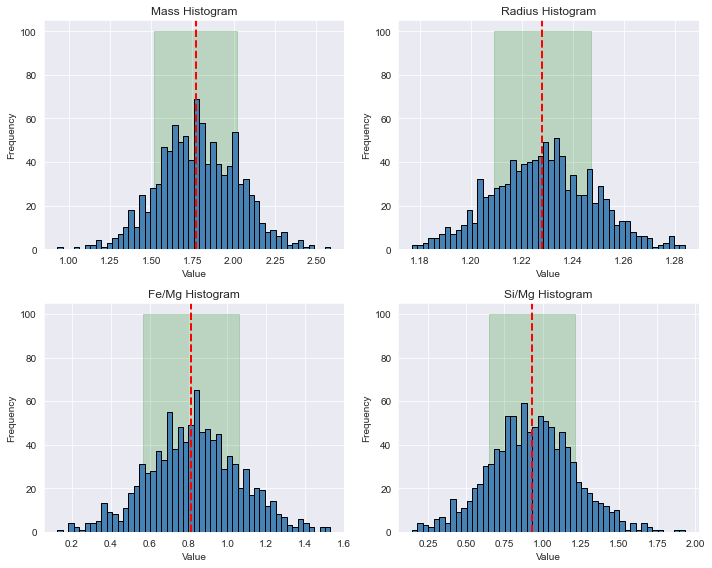

In [11]:
# Create subplots for plotting histograms
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Generate and plot samples for various parameters
mass_samples = generate_samples_and_plot(1.77, 0.25, 'Mass Histogram', axs[0, 0])
radius_samples = generate_samples_and_plot(1.228, 0.019, 'Radius Histogram', axs[0, 1])
femg_samples = generate_samples_and_plot(0.813, 0.248, 'Fe/Mg Histogram', axs[1, 0])
simg_samples = generate_samples_and_plot(0.933, 0.281, 'Si/Mg Histogram', axs[1, 1])

# Combine all samples into an input matrix X
X = np.stack([mass_samples, radius_samples, femg_samples, simg_samples], axis=1)

# Adjust the layout of the subplots
plt.tight_layout()

# Display the histograms
plt.show()

In [13]:
# Define the density storage structure for the outputs
density_x = {param: [] for param in output_parameters}
density_y = {param: [] for param in output_parameters}

# Gaussian Sampling
for input_array in X:
    # Transform input for the model prediction
    scaled_input = scaler_x.transform([input_array])
    pred = m_2.predict(scaled_input)
    
    # Extract the Gaussian mixture parameters
    mus = pred[:, :N_MIXES*OUTPUT_DIMS]
    sigs = pred[:, N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]
    pis = mdn.softmax(pred[:, -N_MIXES:])
    
    # Prepare for the sampling
    y_label = np.arange(0, 1, 0.001).reshape(-1, 1)
    
    # Calculate the Gaussian Mixture Model PDF and sample from it
    for i, output_param in enumerate(output_parameters):
        mus_ = mus[0, i::OUTPUT_DIMS]
        sigs_ = sigs[0, i::OUTPUT_DIMS]
        factors = 1 / math.sqrt(2 * math.pi) / sigs_
        exponent = np.exp(-0.5 * ((y_label - mus_) / sigs_)**2)
        GMM_PDF = np.sum(pis[0] * factors * exponent, axis=1)
        
        # Handling edge cases where the GMM PDF is zero to avoid division by zero
        pdf_nonzero = np.count_nonzero(GMM_PDF)
        if GMM_PDF.sum() ==0:
            index = np.random.choice(y_label[:,0], size=20, replace=True)
        else:
            size = min(20, pdf_nonzero)  # 确保采样大小不超过非零元素数量
            index = np.random.choice(y_label[:,0], size=size, replace=False, p=GMM_PDF/GMM_PDF.sum())
        bins = np.concatenate(([y_label[0, 0]], y_label[:, 0]))
        indices = np.searchsorted(bins, index) - 1
        density_x[output_param]=np.concatenate([density_x[output_param],y_label[:,0][indices]])
        density_y[output_param]=np.concatenate([density_y[output_param],GMM_PDF[indices]])

In [27]:
mus = pred[:, :N_MIXES*OUTPUT_DIMS]
sigs = pred[:, N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]
pis = mdn.softmax(pred[:, -N_MIXES:])

In [31]:
pis[0]

array([0.06344099, 0.04086499, 0.03743485, 0.04070851, 0.04586504,
       0.0444488 , 0.06298548, 0.04730497, 0.04794168, 0.06583356,
       0.03989641, 0.04699802, 0.06881526, 0.0515085 , 0.05020863,
       0.04723894, 0.04087811, 0.05240232, 0.04305666, 0.06216835],
      dtype=float32)

In [14]:
# Plot settings for MDN and MCMC results
x_max = [0.15, 1, 1, 0.1, 1, 2500, 6000, 1.5]
x_locator = [0.05, 0.2, 0.2, 0.02, 0.2, 500, 2000, 0.5]
colors = ["steelblue"] * len(output_parameters)


# Convert density dictionaries into DataFrames for easier manipulation
df_density_x = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in density_x.items()]))
df_density_y = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in density_y.items()]))


# Ensure that the original_x DataFrame has the same index as df_density_y after dropping NaNs
original_x = scaler_y.inverse_transform(df_density_x)

df_k_samples = pd.DataFrame(original_x, columns=output_parameters)

In [16]:
df_k = pd.read_csv("D:\\Resource\\rockyExoplanetV3\\Kepler78b_feo.csv")
df_k["MRF"] = 1 - df_k["WRF"] - df_k["CRF"]

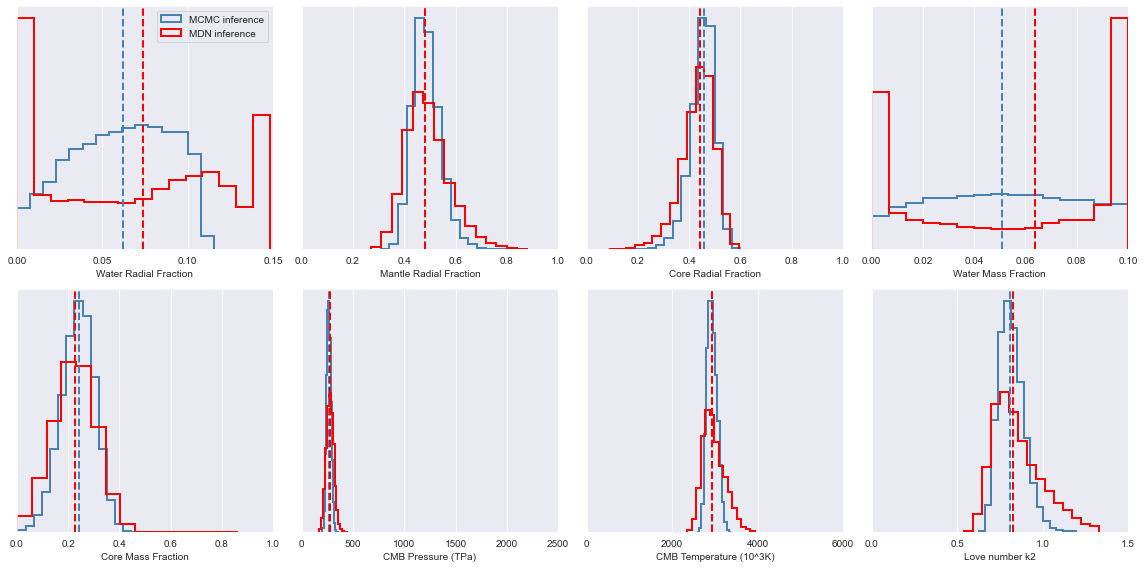

In [17]:
# Plotting comparison histograms for MCMC and MDN results
# Assuming output_parameters, x_max, x_locator are defined as before
# Assuming df_k is the DataFrame containing the MCMC results, loaded as before

x_labels = ['Water Radial Fraction', 'Mantle Radial Fraction', 'Core Radial Fraction', 
            'Water Mass Fraction', 'Core Mass Fraction', 'CMB Pressure (TPa)', 
            'CMB Temperature (10^3K)', 'Love number k2']

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
axs = axs.flatten()

for i, param in enumerate(output_parameters):
    ax = axs[i]
    # plot MCMC results
    x = df_k[param]
    ax.hist(x, density=True, bins=15, histtype='step', color='#4682b4', linewidth=2, label='MCMC inference')
    median = np.median(x)
    ax.axvline(median, color='#4682b4', linestyle='--', lw=2)
    
    # plot MDN results
    params_x = original_x[:,i]
    counts, bins, _ = ax.hist(params_x, density=True, bins=15, histtype='step', color='red', linewidth=2, label='MDN inference')
    median = np.median(params_x)
    ax.axvline(median, color='r', linestyle='--', lw=2)

    # Set x-axis label from the provided list
    ax.set_xlabel(x_labels[i])

    ax.set_xlim(0, x_max[i])
    ax.set_yticks([])
    ax.xaxis.set_major_locator(plt.MultipleLocator(x_locator[i]))
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    # Add legend to the first subplot
    if i == 0:
        ax.legend()

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

# Compare the MCMC and MDN results and calculate the errors
df_k_p = df_k[output_parameters]
q16 = df_k_p.quantile(0.16)
q84 = df_k_p.quantile(0.84)

# MDN statistics
mdn_median = np.median(original_x, axis=0)
mdn_lower_err = mdn_median - np.percentile(original_x, 16, axis=0)
mdn_upper_err = np.percentile(original_x, 84, axis=0) - mdn_median

# MCMC statistics
mcmc_median = df_k_p.median()
mcmc_lower_err = mcmc_median - q16
mcmc_upper_err = q84 - mcmc_median

# Store the results in a DataFrame
results = {
    "Output Parameter": output_parameters,
    "MCMC Median": mcmc_median,
    "MDN Median": mdn_median.tolist(),
    "MCMC Lower Error": mcmc_lower_err,
    "MCMC Upper Error": mcmc_upper_err,
    "MDN Lower Error": mdn_lower_err,
    "MDN Upper Error": mdn_upper_err
}
df_results = pd.DataFrame(results)

In [11]:
# mix = Mixture()
m_y = joblib.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\yscaler.save")
m_x = joblib.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\Xscaler.save")

E:\anaconda\envs\deeplearning\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [43]:
pred = m_2.predict(scaler_x.transform(X))
# sample_function = mdn.get_mixture_sampling_fun(OUTPUT_DIMS, N_MIXES)
# samples = sample_function(pred)

In [12]:
mus = np.apply_along_axis((lambda a: a[:N_MIXES * OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES * OUTPUT_DIMS:2 * N_MIXES * OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)
mus = mus.reshape(mus.shape[0], N_MIXES, int(mus.shape[1] / N_MIXES))
sigs = sigs.reshape(sigs.shape[0], N_MIXES, int(sigs.shape[1] / N_MIXES))

In [14]:
samples = mix(torch.from_numpy(pis), torch.from_numpy(mus), torch.from_numpy(sigs)).sample()

In [5]:
def calculate_GMM(p, m, s, y_label):
    """
    Calculate the probability density function of the Gaussian Mixture Model

        Args:
            - param p: pi
            - param m: mean
            - param s: standard deviation
            - param y_label: e.g. np.arange(0, 1, 0.001)

    """
    if len(y_label.shape) == 1:
        y_label = y_label.reshape(-1, 1)

    y_label_ = y_label[:, np.newaxis, np.newaxis, :]

    mu_sub_T = np.transpose(m, (0, 2, 1))
    sigma_sub_T = np.transpose(s, (0, 2, 1))

    exponent = np.exp(
        -1 / 2 * np.square(np.transpose((y_label_ - mu_sub_T), (1, 2, 0, 3)) / sigma_sub_T[:, :, np.newaxis, :]))
    factors = 1 / math.sqrt(2 * math.pi) / sigma_sub_T[:, :, np.newaxis, :]

    # Shape (number of data, number of y_label, types) e.g.(1000, 10, 8)
    GMM_PDF = np.sum(p[:, np.newaxis, np.newaxis, :] * factors * exponent, axis=-1).transpose((0, -1, 1))
    # GMM_PDF = GMM_PDF.reshape(GMM_PDF.shape[0] * GMM_PDF.shape[1], GMM_PDF.shape[-1]).transpose((-1, 0))
    # f = e.transpose((-1, 0))
    return GMM_PDF

In [6]:
def sampling_from_gmm_pdf(gmm, y_l_):
    bins = np.concatenate(([y_l_[0, 0]], y_l_[:, 0]))
    d_x = {param: [] for param in output_parameters}
    # density_y = {param: [] for param in output_parameters}
    # Loop start here
    for out_param in range(len(output_parameters)):
        GMM_PDF_Tor_sub = gmm[:, :, out_param]
    
        GMM_PDF_Tor_sub_sum = GMM_PDF_Tor_sub.sum(axis=1)[:, np.newaxis]
    
        prob = np.divide(GMM_PDF_Tor_sub, GMM_PDF_Tor_sub_sum)
        non_zero = np.count_nonzero(GMM_PDF_Tor_sub, axis=1)
    
        cond = np.where(GMM_PDF_Tor_sub_sum == 0, True, False)
        p = np.where(cond, 1 / len(y_l_), prob)
        size_cond = np.where((non_zero < 20) & (non_zero > 0), non_zero, np.where(non_zero == 0, 20, 20))
    
        idx = [np.random.choice(y_l_[:, 0], size=size_cond[i], replace=cond[i, 0], p=p[i, :]) for i in range(len(GMM_PDF_Tor_sub))]
        indices = [np.searchsorted(bins, idx[i]) - 1 for i in range(len(idx))]
        flattened_indices = np.concatenate(indices)
        d_x[output_parameters[out_param]] = np.concatenate([d_x[output_parameters[out_param]], y_l_[:, 0][flattened_indices].ravel()])
    
    return d_x

# Kepler 78b


In [7]:
np.random.seed(125)

In [12]:
mass_samples_ori = np.random.normal(1.77, 0, size=1000)
radius_samples_ori = np.random.normal(1.228, 0, size=1000)
femg_samples_ori = np.random.normal(0.813, 0, size=1000)
simg_samples_ori = np.random.normal(0.933, 0, size=1000)

mass_samples = np.random.normal(1.77, 0.25, size=1000)
radius_samples = np.random.normal(1.228, 0.019, size=1000)
femg_samples = np.random.normal(0.813, 0.248, size=1000)
simg_samples = np.random.normal(0.933, 0.281, size=1000)

X_ori = np.stack([mass_samples_ori, radius_samples_ori, femg_samples_ori, simg_samples_ori], axis=1)
X = np.stack([mass_samples, radius_samples, femg_samples, simg_samples], axis=1)

In [13]:
X_com = np.concatenate((m_x.transform(X_ori), m_x.transform(X)), axis=1)
# X_scaled = m_x.transform(X_com)
tensor_x = torch.from_numpy(X_com)
x_o, x_n = tensor_x.chunk(2, dim=1)

In [14]:
pred = model(x_o, x_n)

In [16]:
y_l = np.arange(0, 1, 0.001).reshape(-1, 1)

In [17]:
# (number of range, number of types * number of pred data), e.g. (1000, 8000)
GMM = calculate_GMM(torch.exp(pred[0]).detach().cpu().numpy(), pred[1].detach().cpu().numpy(), pred[2].detach().cpu().numpy(), y_l)

In [18]:
density_x = sampling_from_gmm_pdf(GMM, y_l)

In [19]:
mcmc_result = pd.read_csv("D:\\Resource\\rockyExoplanetV3\\Kepler78b_feo.csv")
mcmc_result["MRF"] = 1 - mcmc_result["WRF"] - mcmc_result["CRF"]

In [20]:
# Convert density dictionaries into DataFrames for easier manipulation
df_density_x = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in density_x.items()]))

# Ensure that the original_x DataFrame has the same index as df_density_y after dropping NaNs
original_x = m_y.inverse_transform(df_density_x)

df_k_samples = pd.DataFrame(original_x, columns=output_parameters)

In [21]:
def plot(mcmc, s_i, o_p):
    x_labels = ['Water Radial Fraction', 'Mantle Radial Fraction', 'Core Radial Fraction', 
                'Water Mass Fraction', 'Core Mass Fraction', 'CMB Pressure (TPa)', 
                'CMB Temperature (10^3K)', 'Love number k2']
    x_max = [0.15, 1, 1, 0.1, 1, 2500, 6000, 1.5]
    x_locator = [0.05, 0.2, 0.2, 0.02, 0.2, 500, 2000, 0.5]
    colors = ["steelblue"] * len(output_parameters)
    
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    axs = axs.flatten()
    for i, param in enumerate(o_p):
        ax = axs[i]
        # plot MCMC results
        x = mcmc[param]
        ax.hist(x, density=True, bins=15, histtype='step', color='#4682b4', linewidth=2, label='MCMC inference')
        median = np.median(x)
        ax.axvline(median, color='#4682b4', linestyle='--', lw=2)
        
        # plot MDN results
        params_x = s_i[:,i]
        counts, bins, _ = ax.hist(params_x, density=True, bins=15, histtype='step', color='red', linewidth=2, label='MDN inference')
        median = np.median(params_x)
        ax.axvline(median, color='r', linestyle='--', lw=2)
        
        # Set x-axis label from the provided list
        ax.set_xlabel(x_labels[i])
    
        ax.set_xlim(0, x_max[i])
        ax.set_yticks([])
        ax.xaxis.set_major_locator(plt.MultipleLocator(x_locator[i]))
        ax.xaxis.set_minor_locator(AutoMinorLocator())
    
        # Add legend to the first subplot
        if i == 0:
            ax.legend()
    
    # Adjust the layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()

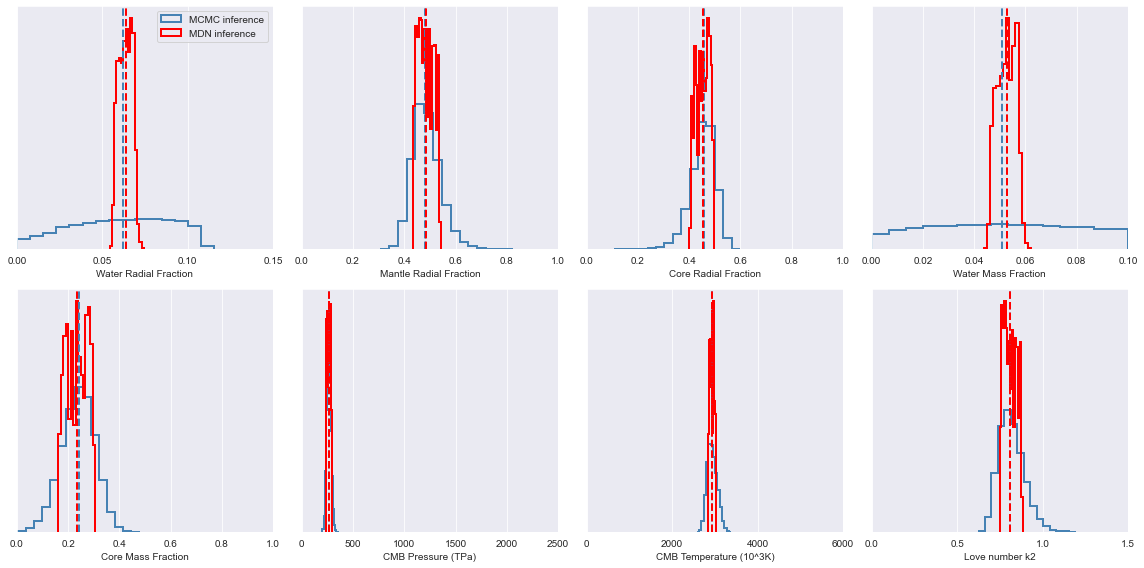

In [22]:
plot(mcmc_result, original_x, output_parameters)

In [23]:
predict_label = [
    "Water radial fraction","Mass radial fraction", "Core radial fraction", 
    "Water mass fraction","Core mass fraction", "CMB pressure (GPa)", "CMB temperature (K)",
    "k2",
]
df_k_p = mcmc_result[output_parameters]
# 从MCMC结果中获取84%和16%的位置误差
q16 = df_k_p.quantile(0.16)
q84 = df_k_p.quantile(0.84)

# 计算MDN结果的中位数和位置误差
median = np.median(original_x, axis=0)
lower_err = median - np.percentile(original_x, q=16, axis=0)
upper_err = np.percentile(original_x, q=84, axis=0) - median

# 计算MCMC结果的中位数和位置误差
mcmc_median = df_k_p.median()
mcmc_lower_err = mcmc_median - q16
mcmc_upper_err = q84 - mcmc_median

# 将所有结果存储在一个DataFrame中
results = {
    "Output Parameter": predict_label,
    "MCMC Median": mcmc_median,
    "MDN Median": median.tolist(),
    "MCMC Lower Error": mcmc_lower_err,
    "MCMC Upper Error": mcmc_upper_err,
    "MDN Lower Error": lower_err,
    "MDN Upper Error": upper_err
}
df_results = pd.DataFrame(results)

# Kepler 10b

In [24]:
mass_samples_ori = np.random.normal(3.72, 0, size=1000)
radius_samples_ori = np.random.normal(1.470, 0, size=1000)
femg_samples_ori = np.random.normal(0.589, 0, size=1000)
simg_samples_ori = np.random.normal(0.661, 0, size=1000)

mass_samples = np.random.normal(3.72, 0.42, size=1000)
radius_samples = np.random.normal(1.470, 0.03, size=1000)
femg_samples = np.random.normal(0.589, 0.073, size=1000)
simg_samples = np.random.normal(0.661, 0.098, size=1000)

X_ori = np.stack([mass_samples_ori, radius_samples_ori, femg_samples_ori, simg_samples_ori], axis=1)
X = np.stack([mass_samples, radius_samples, femg_samples, simg_samples], axis=1)
X_com = np.concatenate((m_x.transform(X_ori), m_x.transform(X)), axis=1)
# X_scaled = m_x.transform(X_com)
tensor_x = torch.from_numpy(X_com)
x_o, x_n = tensor_x.chunk(2, dim=1)

In [25]:
pred = model(x_o, x_n)

In [26]:
y_l = np.arange(0, 1, 0.001).reshape(-1, 1)
# (number of range, number of types * number of pred data), e.g. (1000, 8000)
GMM = calculate_GMM(torch.exp(pred[0]).detach().cpu().numpy(), pred[1].detach().cpu().numpy(),
                    pred[2].detach().cpu().numpy(), y_l)
density_x = sampling_from_gmm_pdf(GMM, y_l)
mcmc_result = pd.read_csv("D:\\Resource\\rockyExoplanetV3\\Kepler10b_feo.csv")
mcmc_result["MRF"] = 1 - mcmc_result["WRF"] - mcmc_result["CRF"]
# Convert density dictionaries into DataFrames for easier manipulation
df_density_x = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in density_x.items()]))

# Ensure that the original_x DataFrame has the same index as df_density_y after dropping NaNs
original_x = m_y.inverse_transform(df_density_x)

df_k_samples = pd.DataFrame(original_x, columns=output_parameters)

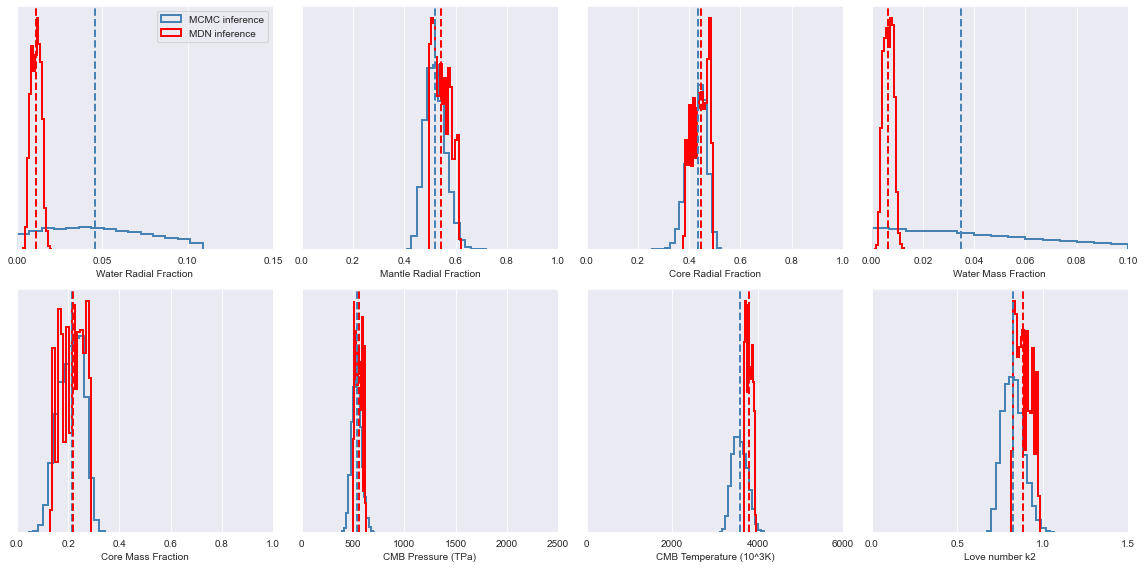

In [27]:
plot(mcmc_result, original_x, output_parameters)

In [28]:
predict_label = [
    "Water radial fraction","Mass radial fraction", "Core radial fraction", 
    "Water mass fraction","Core mass fraction", "CMB pressure (GPa)", "CMB temperature (K)",
    "k2",
]
df_k_p = mcmc_result[output_parameters]
# 从MCMC结果中获取84%和16%的位置误差
q16 = df_k_p.quantile(0.16)
q84 = df_k_p.quantile(0.84)

# 计算MDN结果的中位数和位置误差
median = np.median(original_x, axis=0)
lower_err = median - np.percentile(original_x, q=16, axis=0)
upper_err = np.percentile(original_x, q=84, axis=0) - median

# 计算MCMC结果的中位数和位置误差
mcmc_median = df_k_p.median()
mcmc_lower_err = mcmc_median - q16
mcmc_upper_err = q84 - mcmc_median

# 将所有结果存储在一个DataFrame中
results = {
    "Output Parameter": predict_label,
    "MCMC Median": mcmc_median,
    "MDN Median": median.tolist(),
    "MCMC Lower Error": mcmc_lower_err,
    "MCMC Upper Error": mcmc_upper_err,
    "MDN Lower Error": lower_err,
    "MDN Upper Error": upper_err
}
df_results = pd.DataFrame(results)

# HD 3167 b

In [30]:
mass_samples_ori = np.random.normal(5.69, 0, size=1000)
radius_samples_ori = np.random.normal(1.574, 0, size=1000)
femg_samples_ori = np.random.normal(0.692, 0, size=1000)
simg_samples_ori = np.random.normal(0.692, 0, size=1000)

mass_samples = np.random.normal(5.69, 0.44, size=1000)
radius_samples = np.random.normal(1.574, 0.054, size=1000)
femg_samples = np.random.normal(0.692, 0.103, size=1000)
simg_samples = np.random.normal(0.692, 0.130, size=1000)

X_ori = np.stack([mass_samples_ori, radius_samples_ori, femg_samples_ori, simg_samples_ori], axis=1)
X = np.stack([mass_samples, radius_samples, femg_samples, simg_samples], axis=1)
X_com = np.concatenate((m_x.transform(X_ori), m_x.transform(X)), axis=1)
# X_scaled = m_x.transform(X_com)
tensor_x = torch.from_numpy(X_com)
x_o, x_n = tensor_x.chunk(2, dim=1)

In [31]:
pred = model(x_o, x_n)

In [32]:
y_l = np.arange(0, 1, 0.001).reshape(-1, 1)
# (number of range, number of types * number of pred data), e.g. (1000, 8000)
GMM = calculate_GMM(torch.exp(pred[0]).detach().cpu().numpy(), pred[1].detach().cpu().numpy(),
                    pred[2].detach().cpu().numpy(), y_l)
density_x = sampling_from_gmm_pdf(GMM, y_l)
mcmc_result = pd.read_csv("D:\\Resource\\rockyExoplanetV3\\HD3167b_feo.csv")
mcmc_result["MRF"] = 1 - mcmc_result["WRF"] - mcmc_result["CRF"]
# Convert density dictionaries into DataFrames for easier manipulation
df_density_x = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in density_x.items()]))

# Ensure that the original_x DataFrame has the same index as df_density_y after dropping NaNs
original_x = m_y.inverse_transform(df_density_x)

df_k_samples = pd.DataFrame(original_x, columns=output_parameters)

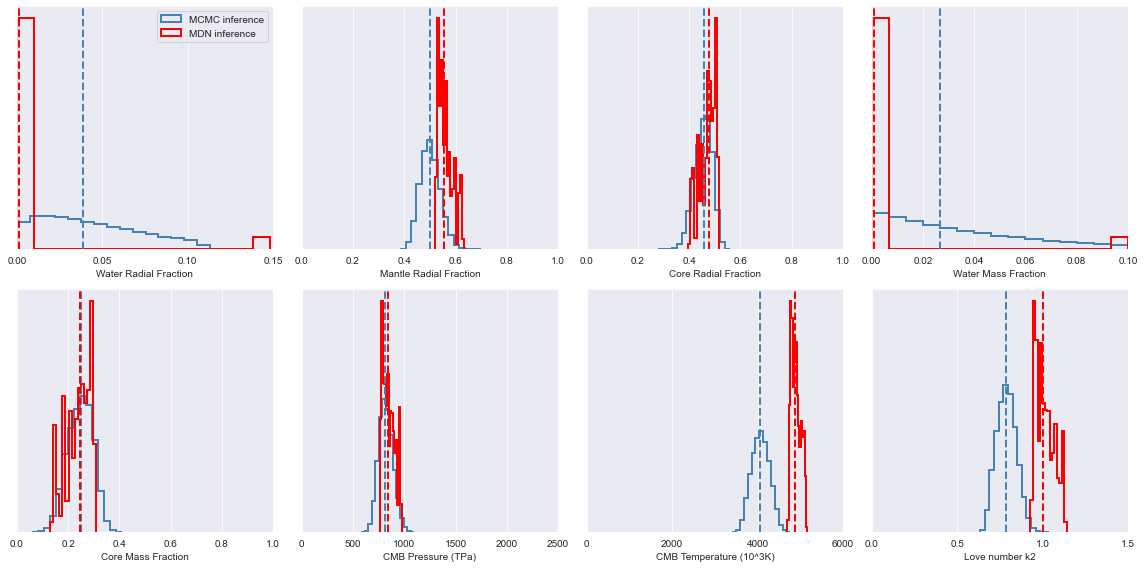

In [33]:
plot(mcmc_result, original_x, output_parameters)

In [34]:
predict_label = [
    "Water radial fraction","Mass radial fraction", "Core radial fraction", 
    "Water mass fraction","Core mass fraction", "CMB pressure (GPa)", "CMB temperature (K)",
    "k2",
]
df_k_p = mcmc_result[output_parameters]
# 从MCMC结果中获取84%和16%的位置误差
q16 = df_k_p.quantile(0.16)
q84 = df_k_p.quantile(0.84)

# 计算MDN结果的中位数和位置误差
median = np.median(original_x, axis=0)
lower_err = median - np.percentile(original_x, q=16, axis=0)
upper_err = np.percentile(original_x, q=84, axis=0) - median

# 计算MCMC结果的中位数和位置误差
mcmc_median = df_k_p.median()
mcmc_lower_err = mcmc_median - q16
mcmc_upper_err = q84 - mcmc_median

# 将所有结果存储在一个DataFrame中
results = {
    "Output Parameter": predict_label,
    "MCMC Median": mcmc_median,
    "MDN Median": median.tolist(),
    "MCMC Lower Error": mcmc_lower_err,
    "MCMC Upper Error": mcmc_upper_err,
    "MDN Lower Error": lower_err,
    "MDN Upper Error": upper_err
}
df_results = pd.DataFrame(results)

# HD 219134b

In [39]:
mass_samples_ori = np.random.normal(4.74, 0, size=1000)
radius_samples_ori = np.random.normal(1.602, 0, size=1000)
femg_samples_ori = np.random.normal(0.794, 0, size=1000)
simg_samples_ori = np.random.normal(0.871, 0, size=1000)

mass_samples = np.random.normal(4.74, 0.19, size=1000)
radius_samples = np.random.normal(1.602, 0.055, size=1000)
femg_samples = np.random.normal(0.794, 0.154, size=1000)
simg_samples = np.random.normal(0.871, 0.195, size=1000)

X_ori = np.stack([mass_samples_ori, radius_samples_ori, femg_samples_ori, simg_samples_ori], axis=1)
X = np.stack([mass_samples, radius_samples, femg_samples, simg_samples], axis=1)
X_com = np.concatenate((m_x.transform(X_ori), m_x.transform(X)), axis=1)
# X_scaled = m_x.transform(X_com)
tensor_x = torch.from_numpy(X_com)
x_o, x_n = tensor_x.chunk(2, dim=1)

In [40]:
pred = model(x_o, x_n)

In [41]:
y_l = np.arange(0, 1, 0.001).reshape(-1, 1)
# (number of range, number of types * number of pred data), e.g. (1000, 8000)
GMM = calculate_GMM(pred[0].detach().cpu().numpy(), pred[1].detach().cpu().numpy(),
                    pred[2].detach().cpu().numpy(), y_l)
density_x = sampling_from_gmm_pdf(GMM, y_l)
mcmc_result = pd.read_csv("D:\\Resource\\rockyExoplanetV3\\HD219134b_feo.csv")
mcmc_result["MRF"] = 1 - mcmc_result["WRF"] - mcmc_result["CRF"]
# Convert density dictionaries into DataFrames for easier manipulation
df_density_x = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in density_x.items()]))

# Ensure that the original_x DataFrame has the same index as df_density_y after dropping NaNs
original_x = m_y.inverse_transform(df_density_x)

df_k_samples = pd.DataFrame(original_x, columns=output_parameters)

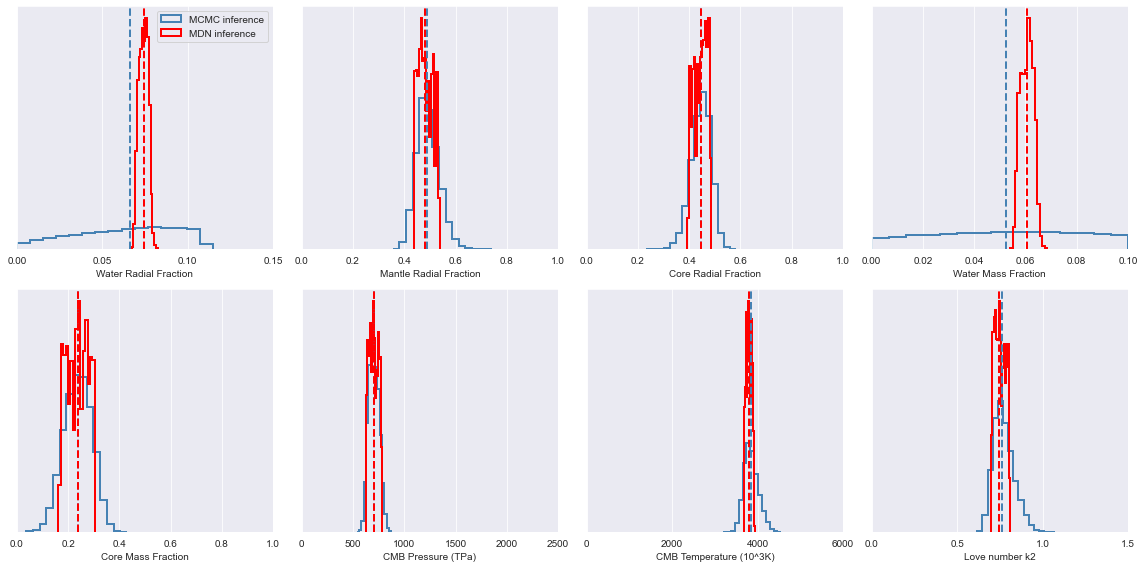

In [42]:
plot(mcmc_result, original_x, output_parameters)

In [43]:
predict_label = [
    "Water radial fraction","Mass radial fraction", "Core radial fraction", 
    "Water mass fraction","Core mass fraction", "CMB pressure (GPa)", "CMB temperature (K)",
    "k2",
]
df_k_p = mcmc_result[output_parameters]
# 从MCMC结果中获取84%和16%的位置误差
q16 = df_k_p.quantile(0.16)
q84 = df_k_p.quantile(0.84)

# 计算MDN结果的中位数和位置误差
median = np.median(original_x, axis=0)
lower_err = median - np.percentile(original_x, q=16, axis=0)
upper_err = np.percentile(original_x, q=84, axis=0) - median

# 计算MCMC结果的中位数和位置误差
mcmc_median = df_k_p.median()
mcmc_lower_err = mcmc_median - q16
mcmc_upper_err = q84 - mcmc_median

# 将所有结果存储在一个DataFrame中
results = {
    "Output Parameter": predict_label,
    "MCMC Median": mcmc_median,
    "MDN Median": median.tolist(),
    "MCMC Lower Error": mcmc_lower_err,
    "MCMC Upper Error": mcmc_upper_err,
    "MDN Lower Error": lower_err,
    "MDN Upper Error": upper_err
}
df_results = pd.DataFrame(results)

# EPIC 249893012 b

In [50]:
mass_samples_ori = np.random.normal(8.75, 0, size=1000)
radius_samples_ori = np.random.normal(1.95, 0, size=1000)
femg_samples_ori = np.random.normal(0.692, 0, size=1000)
simg_samples_ori = np.random.normal(0.741, 0, size=1000)

mass_samples = np.random.normal(8.75, 1.09, size=1000)
radius_samples = np.random.normal(1.95, 0.09, size=1000)
femg_samples = np.random.normal(0.692, 0.124, size=1000)
simg_samples = np.random.normal(0.741, 0.134, size=1000)

X_ori = np.stack([mass_samples_ori, radius_samples_ori, femg_samples_ori, simg_samples_ori], axis=1)
X = np.stack([mass_samples, radius_samples, femg_samples, simg_samples], axis=1)
X_com = np.concatenate((m_x.transform(X_ori), m_x.transform(X)), axis=1)
# X_scaled = m_x.transform(X_com)
tensor_x = torch.from_numpy(X_com)
x_o, x_n = tensor_x.chunk(2, dim=1)

In [51]:
pred = model(x_o, x_n)

In [52]:
y_l = np.arange(0, 1, 0.001).reshape(-1, 1)
# (number of range, number of types * number of pred data), e.g. (1000, 8000)
GMM = calculate_GMM(torch.exp(pred[0]).detach().cpu().numpy(), pred[1].detach().cpu().numpy(),
                    pred[2].detach().cpu().numpy(), y_l)
density_x = sampling_from_gmm_pdf(GMM, y_l)
mcmc_result = pd.read_csv("D:\\Resource\\rockyExoplanetV3\\EPIC249893012b_feo.csv")
mcmc_result["MRF"] = 1 - mcmc_result["WRF"] - mcmc_result["CRF"]
# Convert density dictionaries into DataFrames for easier manipulation
df_density_x = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in density_x.items()]))

# Ensure that the original_x DataFrame has the same index as df_density_y after dropping NaNs
original_x = m_y.inverse_transform(df_density_x)

df_k_samples = pd.DataFrame(original_x, columns=output_parameters)

E:\anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


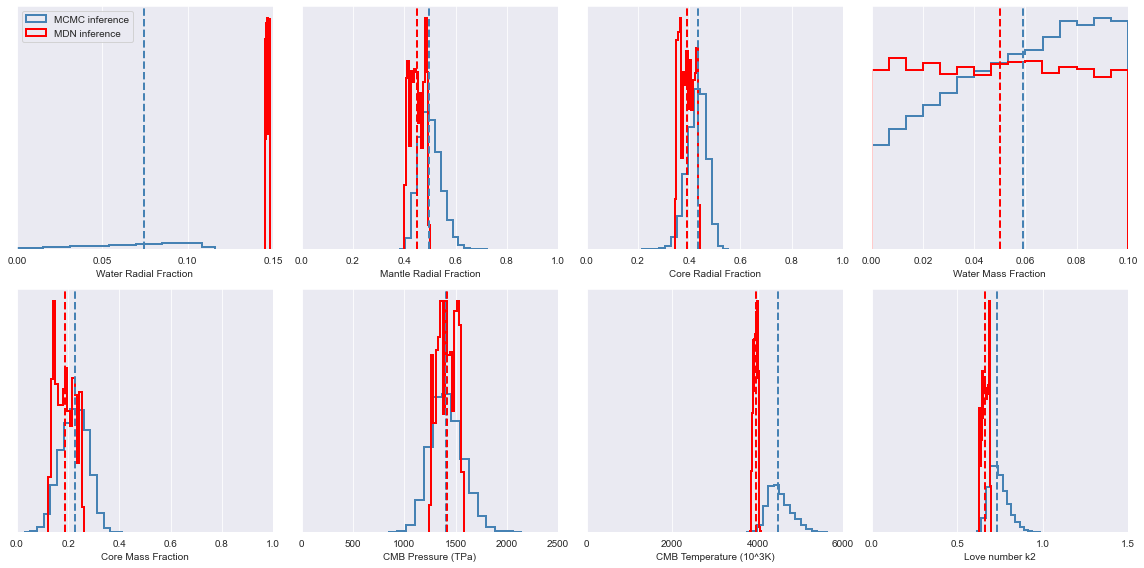

In [53]:
plot(mcmc_result, original_x, output_parameters)


In [54]:
predict_label = [
    "Water radial fraction","Mass radial fraction", "Core radial fraction", 
    "Water mass fraction","Core mass fraction", "CMB pressure (GPa)", "CMB temperature (K)",
    "k2",
]
df_k_p = mcmc_result[output_parameters]
# 从MCMC结果中获取84%和16%的位置误差
q16 = df_k_p.quantile(0.16)
q84 = df_k_p.quantile(0.84)

# 计算MDN结果的中位数和位置误差
median = np.median(original_x, axis=0)
lower_err = median - np.percentile(original_x, q=16, axis=0)
upper_err = np.percentile(original_x, q=84, axis=0) - median

# 计算MCMC结果的中位数和位置误差
mcmc_median = df_k_p.median()
mcmc_lower_err = mcmc_median - q16
mcmc_upper_err = q84 - mcmc_median

# 将所有结果存储在一个DataFrame中
results = {
    "Output Parameter": predict_label,
    "MCMC Median": mcmc_median,
    "MDN Median": median.tolist(),
    "MCMC Lower Error": mcmc_lower_err,
    "MCMC Upper Error": mcmc_upper_err,
    "MDN Lower Error": lower_err,
    "MDN Upper Error": upper_err
}
df_results = pd.DataFrame(results)